In [1]:
import torch
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
import pandas as pd
import numpy as np

In [2]:
import PIL

In [3]:
pipeline=transforms.Compose([transforms.ToTensor()])

In [4]:
import os
path_imgs="../sony/data/guns-object-detection/Images"
path_labels="../sony/data/guns-object-detection/Labels"

In [31]:
class GunsData(Dataset):
    def __init__(self,path_imgs,path_labels):
        self.img_names=os.listdir(path_imgs)
        self.path_imgs=path_imgs
        self.path_labels=path_labels
    def __len__(self):
        return len(self.img_names)
    def __getitem__(self,idx):
        path_to_img=os.path.join(path_imgs,self.img_names[idx])
        img=PIL.Image.open(path_to_img)
        img=pipeline(img)
        label_name=self.img_names[idx].split(".")[0]+".txt"
        path_to_labels=os.path.join(path_labels,label_name)
        con=open(path_to_labels)
        labels=con.readlines()
        con.close()
        boxes=[]
        for label in labels[1:]:
            xmin,ymin,xmax,ymax=label.split(" ")
            xmin=float(xmin)
            ymin=float(ymin)
            xmax=float(xmax)
            ymax=float(ymax)
            boxes.append([xmin,ymin,xmax,ymax])
        boxes=torch.tensor(boxes)
        target={}
        target['boxes']=boxes
        target['area']=(boxes[:,3]-boxes[:,1])*(boxes[:,2]-boxes[:,0])
        target['labels']= torch.tensor([1]*boxes.shape[0],dtype=torch.int64)
        target['image_id']=torch.tensor(int(self.img_names[idx].split(".")[0]),dtype=torch.int64)
        target['iscrowd']= torch.tensor([0]*boxes.shape[0],dtype=torch.int64)
        return img,target

In [32]:
d=GunsData(path_imgs,path_labels)

In [33]:
next(iter(d))

(tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.9843, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.9725, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.9333, 0.9765, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
          [0.9098, 0.9608, 0.9843,  ..., 1.0000, 1.0000, 1.0000],
          [0.9843, 0.9843, 0.9922,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ...,

In [34]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [35]:
import torchvision.models as models

In [36]:
model=models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [37]:
num_classes=2

In [38]:
in_features=model.roi_heads.box_predictor.cls_score.in_features

In [39]:
model.roi_heads.box_predictor=FastRCNNPredictor(in_features,num_classes)

In [40]:
### batch, images are of diff/number of objects in the images will be different
### collate_fn

In [41]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [42]:
### ((I1_img,I1_y),())

In [43]:
dataset=DataLoader(d,batch_size=2,collate_fn=collate_fn)

In [44]:
images,targets=next(iter(dataset))

In [45]:
targets

({'boxes': tensor([[ 64.,  43., 202., 108.]]),
  'area': tensor([8970.]),
  'labels': tensor([1]),
  'image_id': tensor(236),
  'iscrowd': tensor([0])},
 {'boxes': tensor([[111.,  40., 136.,  67.],
          [194., 101., 227., 135.]]),
  'area': tensor([ 675., 1122.]),
  'labels': tensor([1, 1]),
  'image_id': tensor(47),
  'iscrowd': tensor([0, 0])})

In [46]:
import torch.optim as optim

In [47]:
opt=optim.Adagrad(model.parameters())

In [48]:
images=list(image for image in images)

In [49]:
targets=[{k:v for k,v in t.items()} for t in targets ]

In [50]:
output=model(images,targets)

In [51]:
output

{'loss_classifier': tensor(0.8063, grad_fn=<NllLossBackward>),
 'loss_box_reg': tensor(0.1390, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0220, grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_rpn_box_reg': tensor(0.0141, grad_fn=<DivBackward0>)}

In [54]:
loss=sum([v for k,v in output.items()])

In [55]:
loss.backward()

In [56]:
opt.step()
opt.zero_grad()

In [57]:
'''epochs=10
for i in range(epochs):
    for images,targets in dataset:
        images=list(image for image in images)
        targets=[{k:v for k,v in t.items()} for t in targets ]
        output=model(images,targets)
        loss=sum([v for k,v in output.items()])
        loss.backward()
        opt.step()
        opt.zero_grad()'''

'epochs=10\nfor i in range(epochs):\n    for images,targets in dataset:\n        images=list(image for image in images)\n        targets=[{k:v for k,v in t.items()} for t in targets ]\n        output=model(images,targets)\n        loss=sum([v for k,v in output.items()])\n        loss.backward()\n        opt.step()\n        opt.zero_grad()'

In [58]:
#### YoloV3 how can I compute anchor boxes
anchor=[1.19,1.99]

In [59]:
x_feature=7
y_feature=7

In [64]:
cx_image=(7*32+6*32)/2
cy_image=(7*32+6*32)/2

In [65]:
cx_image

208.0

In [66]:
cy_image

208.0

In [67]:
w=1.19*32
h=1.99*32

In [68]:
x1=208-w/2
x2=208+w/2
y1=208-h/2
y2=208+h/2

In [69]:
x1

188.96

In [70]:
x2

227.04

In [71]:
y1

176.16

In [72]:
y2

239.84

In [73]:
anchor=0.99,1.21

In [74]:
path="/Users/gunnvantsaini/OneDrive/project_codes/content/dl_basics/sony/data/guns-object-detection/Images/1.jpeg"
img=PIL.Image.open(path)

In [75]:
img.width

347

In [76]:
img.height

145

In [77]:
from torch import nn

In [78]:
vgg16=models.vgg16(pretrained=True)

In [79]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [80]:
vgg16.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [84]:
nn.Conv2d(4096,4096,kernel_size=1).weight.data.shape

torch.Size([4096, 4096, 1, 1])

In [91]:
class FCN32(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        model=models.vgg16(pretrained=True)
        features=model.features
        classifier=model.classifier
        features[0].padding=(100,100)
        self.feature5=features
        self.num_classes=num_classes
        fc6=nn.Conv2d(512,4096,kernel_size=7)
        fc6.weight.data.copy_(classifier[0].weight.data.view(4096,512,7,7))
        fc6.bias.data.copy_(classifier[0].bias.data)
        fc7=nn.Conv2d(4096,4096,kernel_size=1)
        fc7.weight.data.copy_(classifier[3].weight.data.view(4096,4096,1,1))
        fc7.bias.data.copy_(classifier[3].bias.data)
        scores=nn.Conv2d(4096,self.num_classes,kernel_size=1)
        self.scores=nn.Sequential(fc6,nn.ReLU(),fc7,nn.ReLU(),scores) ### (1,2,7,7)
        self.upsample=nn.ConvTranspose2d(self.num_classes,num_classes,stride=32,kernel_size=64,bias=False)
    def forward(self,X):
        X_size=X.size()
        X=self.feature5(X)
        X=self.scores(X)
        X=self.upsample(X)
        X=torch.sigmoid(X)
        return X[:,:,16:16+X_size[2],16:16+X_size[3]]

In [92]:
m=FCN32(2)

In [93]:
sample=torch.randn(1,3,224,224)

In [94]:
m(sample).shape

torch.Size([1, 2, 224, 224])

In [95]:
### Target Size
### Current Size
### diff
### New ht=diff/2:diff/2+target_size
### New width= diff/2:diff2+target_size

In [96]:
### Pretraied segmentation model
fcn=models.segmentation.fcn_resnet101(pretrained=True)

In [97]:
min_image_size=520
transform_pipeline=transforms.Compose([transforms.Resize((min_image_size,min_image_size)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

In [98]:
img=PIL.Image.open("../sony/data/airplane.jpg")

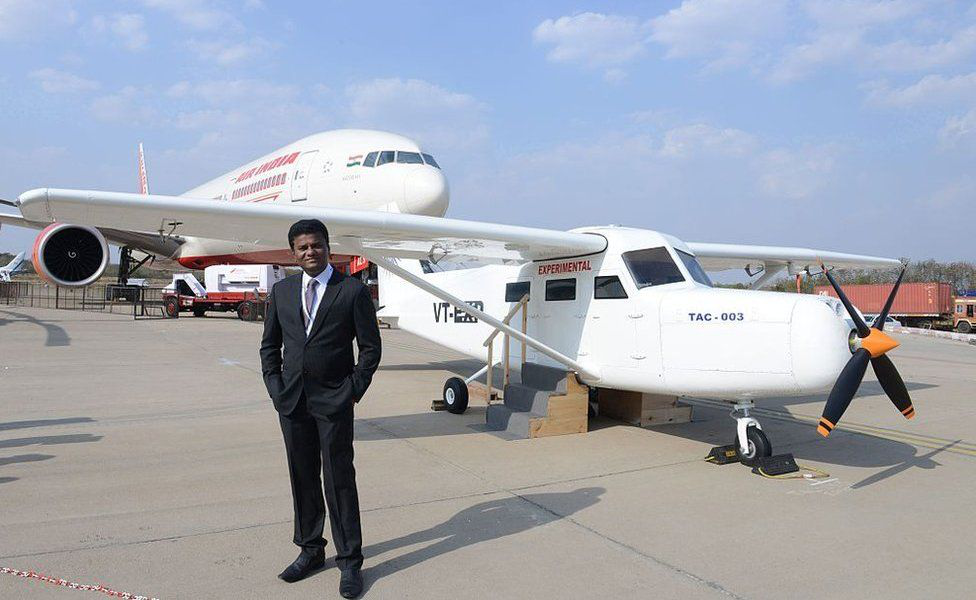

In [99]:
img

In [100]:
img=transform_pipeline(img)
img=img.unsqueeze(0)

In [101]:
fcn.eval()

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [102]:
prediction=fcn(img)

In [104]:
prediction['out'].shape

torch.Size([1, 21, 520, 520])

In [105]:
id_2_cats=['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [106]:
len(id_2_cats)

21

In [109]:
mask=prediction['out'].argmax(1)

In [111]:
mask.shape

torch.Size([1, 520, 520])

In [113]:
import matplotlib.pyplot as plt
%matplotlib inline

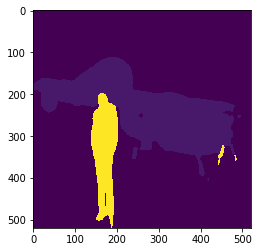

In [117]:
plt.imshow(mask.numpy().reshape((520,520)))

In [118]:
mask.unique()

tensor([ 0,  1, 15])

In [119]:
id_2_cats[15]

'person'

In [120]:
import cv2

In [169]:
foreground=PIL.Image.open("../sony/data/cow.jpg")

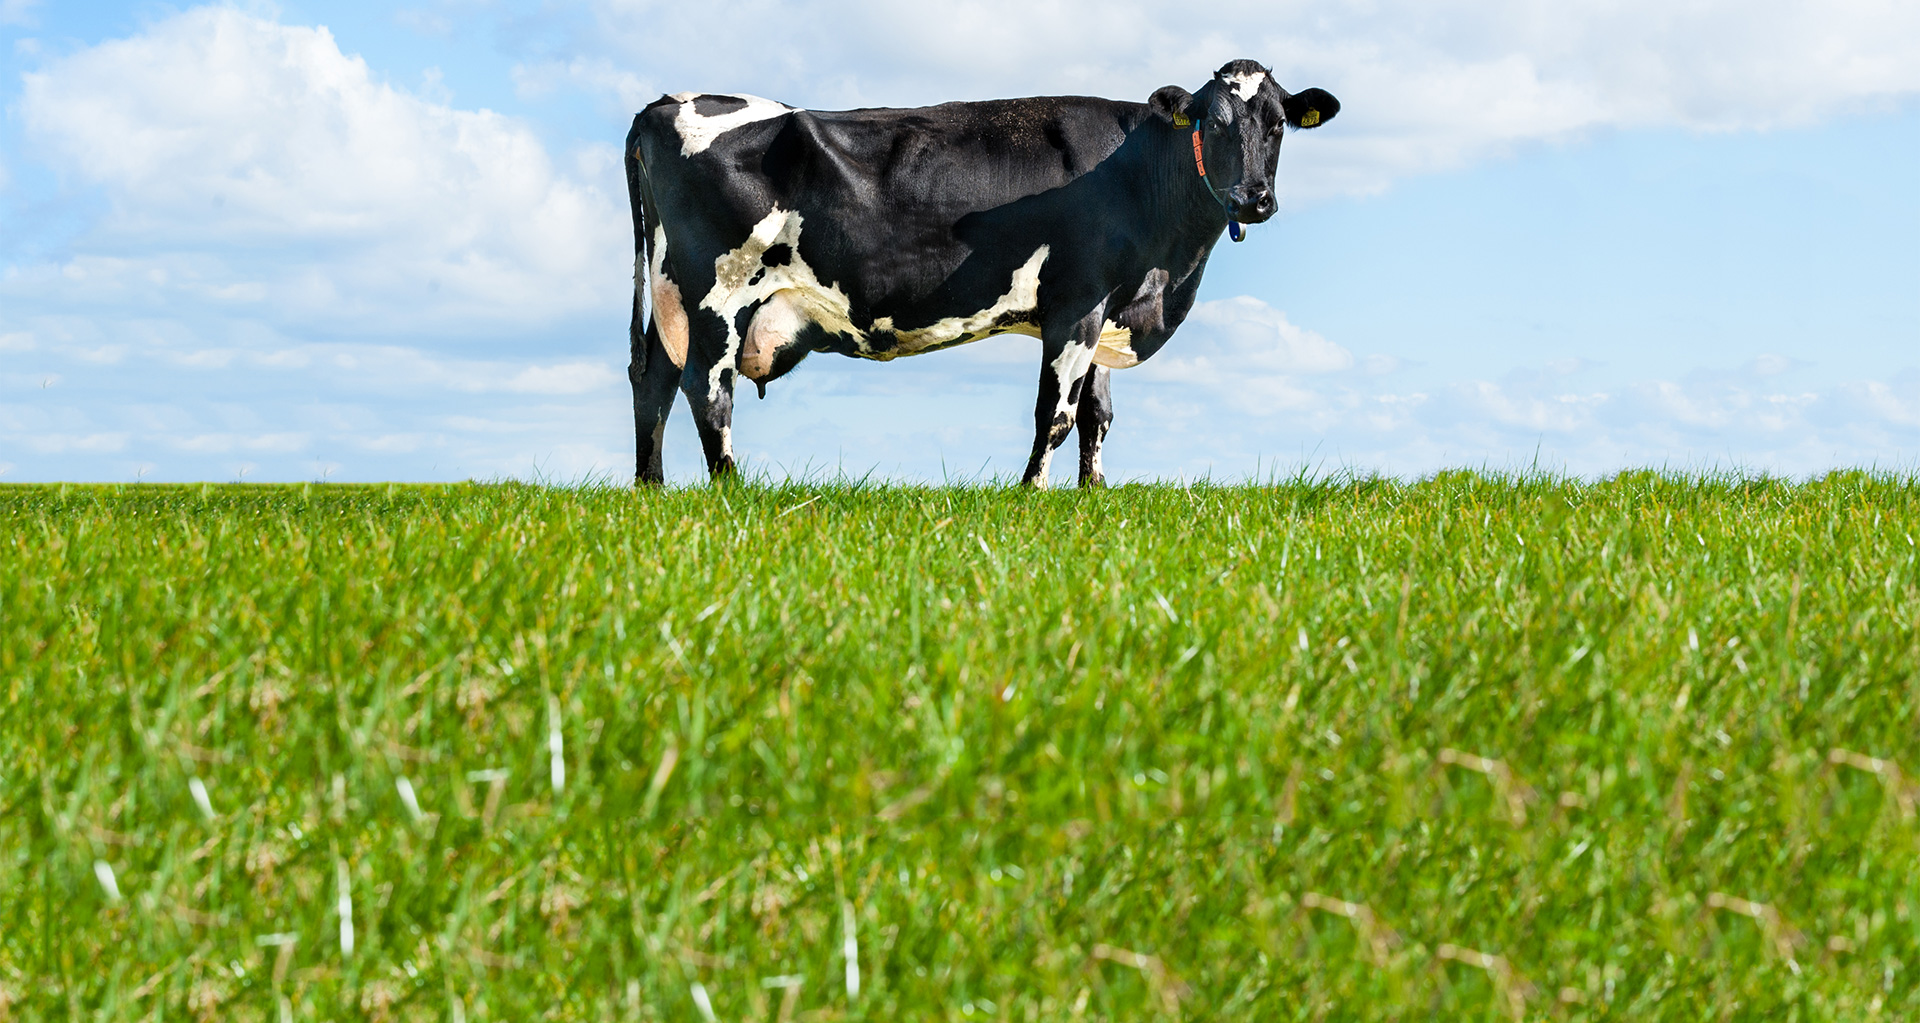

In [170]:
foreground

In [123]:
background=PIL.Image.open("../sony/data/desert.jpg")

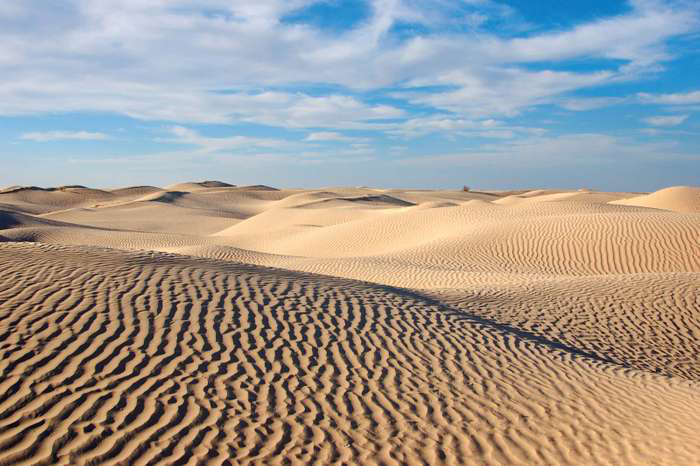

In [124]:
background

In [171]:
img=transform_pipeline(foreground)

In [172]:
img=img.unsqueeze(0)

In [173]:
img.shape

torch.Size([1, 3, 520, 520])

In [174]:
deeplab=models.segmentation.deeplabv3_resnet101(pretrained=True)

In [175]:
deeplab.eval()
preds=deeplab(img)

In [176]:
mask=preds['out'].argmax(1)

In [177]:
mask.shape

torch.Size([1, 520, 520])

In [178]:
id_2_cats[10]

'cow'

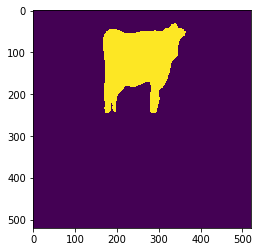

In [179]:
plt.imshow(mask.numpy().astype("float").reshape((520,520)))

In [180]:
color_map=np.array([[0,0,0],
                   [255,0,0],
                   [0,255,0],
                   [0,0,255],
                   [255,255,0],
                   [0,255,255],
                   [255,0,255],
                   [0,0,128],
                   [139,0,139],
                   [139,69,19],
                   [30,144,255],
                   [255,215,0],
                   [128,128,0],
                   [0,255,255],
                   [70,130,180],
                   [199,21,133],
                   [210,105,30],
                   [188,143,143],
                   [112,128,144],
                   [28,128,0],
                   [0,128,128]])

In [188]:
color_map.shape

(21, 3)

In [181]:
mask=mask.numpy()

In [186]:
Mask=color_map[mask.reshape(520,520)]

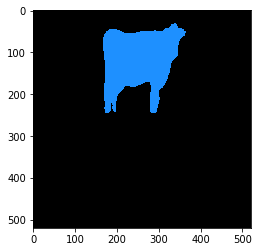

In [187]:
plt.imshow(Mask)

In [189]:
background=cv2.imread("../sony/data/desert.jpg")

In [190]:
foreground=cv2.imread("../sony/data/cow.jpg")

In [191]:
background.shape ### RGB, BGR

(466, 700, 3)

In [192]:
foreground.shape

(1023, 1920, 3)

In [193]:
foreground=cv2.cvtColor(foreground,cv2.COLOR_BGR2RGB)

In [194]:
background=cv2.cvtColor(background,cv2.COLOR_BGR2RGB)

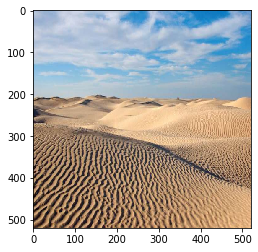

In [202]:
plt.imshow(background.astype("uint8"))

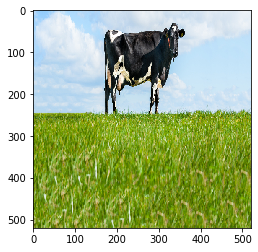

In [203]:
plt.imshow(foreground.astype("uint8"))

In [197]:
background=cv2.resize(background,(520,520))
foreground=cv2.resize(foreground,(520,520))

In [198]:
background=background.astype(float)
foreground=foreground.astype(float)

In [204]:
th,alpha=cv2.threshold(Mask.astype("uint8"),0,255,cv2.THRESH_BINARY)

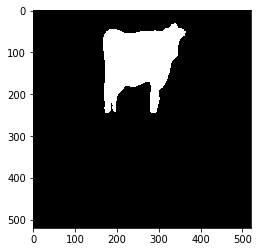

In [205]:
plt.imshow(alpha)

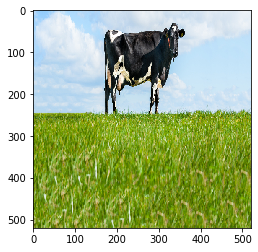

In [206]:
plt.imshow(foreground.astype("uint8"))

In [211]:
alpha=alpha.astype('float')/255

In [212]:
foreground=cv2.multiply(alpha,foreground)

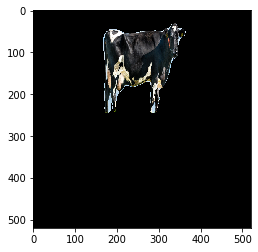

In [213]:
plt.imshow(foreground.astype('uint8'))

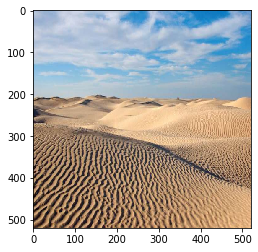

In [214]:
plt.imshow(background.astype("uint8"))

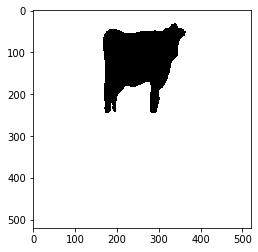

In [216]:
plt.imshow(1-alpha)

In [217]:
background=cv2.multiply(1.0-alpha,background)

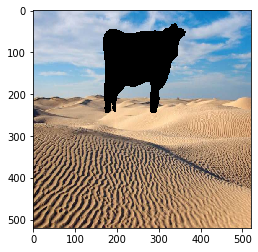

In [218]:
plt.imshow(background.astype("uint8"))

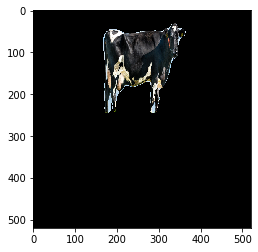

In [219]:
plt.imshow(foreground.astype('uint8'))

In [220]:
result=cv2.add(foreground,background)

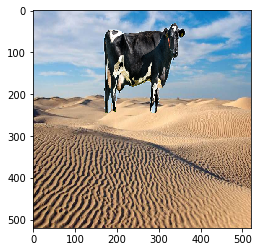

In [221]:
plt.imshow(result.astype("uint8"))

In [222]:
### Train your own segmentation model?
fcn=models.segmentation.fcn_resnet50(num_classes=2)

In [223]:
class SegData(Dataset):
    def __init__(self,image_names,image_path,mask_names,mask_path,min_size=224):
        self.image_names=image_names
        self.image_path=image_path
        self.mask_names=mask_names
        self.mask_path=mask_path
        self.min_size=min_size
    def __len__(self):
        return len(self.image_names)
    def __getitem__(self,idx):
        path_to_image=os.path.join(self.image_path,self.image_names[idx])
        path_to_mask=os.path.join(self.mask_path,self.mask_names[idx])
        img=cv2.imread(path_to_image)
        img=cv2.resize(img,(self.min_size,self.min_size))
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        
        mask=cv2.imread(path_to_mask)
        mask=cv2.resize(mask,(self.min_size,self.min_size))
        mask=cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
        batch={'X':img,'y':mask}
        return batch

In [224]:
image_path="/Users/gunnvantsaini/OneDrive/project_codes/content/dl_basics/sony/data/nails-segmentation/images"
image_names=os.listdir(image_path)
mask_path="/Users/gunnvantsaini/OneDrive/project_codes/content/dl_basics/sony/data/nails-segmentation/labels"
mask_names=os.listdir(mask_path)


In [225]:
seg_data=SegData(image_names,image_path,mask_names,mask_path)

In [226]:
next(iter(seg_data))

{'X': array([[[ 16,  15,   1],
         [ 12,  10,   0],
         [ 13,   7,   0],
         ...,
         [ 19,  20,  14],
         [ 18,  21,  12],
         [ 21,  22,  12]],
 
        [[180, 182, 166],
         [176, 172, 157],
         [169, 163, 150],
         ...,
         [ 19,  21,  15],
         [ 17,  20,  13],
         [ 21,  21,  13]],
 
        [[194, 193, 178],
         [192, 193, 178],
         [193, 195, 179],
         ...,
         [ 19,  21,  13],
         [ 19,  21,  12],
         [ 19,  21,  13]],
 
        ...,
 
        [[148, 104,  69],
         [146, 105,  68],
         [147, 107,  71],
         ...,
         [ 28,  47,  58],
         [ 33,  52,  62],
         [ 43,  60,  75]],
 
        [[149, 110,  73],
         [152, 112,  75],
         [146, 108,  71],
         ...,
         [ 27,  50,  62],
         [ 25,  44,  58],
         [ 37,  55,  69]],
 
        [[150, 110,  75],
         [149, 108,  73],
         [148, 110,  74],
         ...,
         [ 46,  65,  77